#### Libraries & Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Additional libraries
from warnings import filterwarnings
filterwarnings('ignore')

# Setting random seed value
np.random.seed(42)
print(f"Necessary packages are installed...!!!")

Necessary packages are installed...!!!


#### Function for Pre-processing, Modelling and Validations

In [2]:
# Constructing a function for visualising the distribution
def plot_numeric_distributions(
    df: pd.DataFrame,
    num_cols: list,
    color: str = "maroon",
    kde: bool = True,
    bins: int = 30,
    figsize: tuple = (10, 5)
):

    for col in num_cols:
        data = df[col].dropna()

        plt.figure(figsize=figsize)
        sns.histplot(
            data,
            bins=bins,
            kde=kde,
            color=color
        )
        plt.title(col)
        plt.tight_layout()
        plt.show()

#### Data Fabrication

In [3]:
# Variable for number of records
n_records = 100000
n_skus = 10000   # total distinct SKUs

# Market & Customer Factors
customer_ids = np.random.randint(1000, 5000, size=n_records)
segments = np.random.choice(['Budget', 'Standard', 'Premium'], size=n_records, p=[0.4, 0.4, 0.2])
season = np.random.choice(['Holiday', 'Off-season', 'Regular'], size=n_records, p=[0.2, 0.3, 0.5])
time_of_day = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], size=n_records)
days_since_last_purchase = np.random.exponential(scale=10, size=n_records).astype(int)
base_demand = np.random.normal(100, 20, size=n_records)

# Supply & Operational Factors
inventory_level = np.random.randint(10, 500, size=n_records)
capacity_utilization = np.random.uniform(0.5, 1.2, size=n_records)
production_cost = np.random.normal(50, 10, size=n_records)
perishability = np.random.choice([0, 1], size=n_records, p=[0.7, 0.3])
cross_product_effect = np.random.normal(0, 5, size=n_records)

# External & Competitive Factors
competitor_price = np.random.normal(100, 15, size=n_records)
market_positioning = np.random.choice(['Low', 'Mid', 'High'], size=n_records, p=[0.3, 0.5, 0.2])
macroeconomic_index = np.random.normal(1.0, 0.1, size=n_records)
weather = np.random.choice(['Sunny', 'Rainy', 'Cold', 'Hot'], size=n_records)

# SKU IDs (10,000 unique SKUs randomly assigned across 100,000 records)
sku_pool = [f"SKU-{i:05d}" for i in range(n_skus)]
sku_ids = np.random.choice(sku_pool, size=n_records, replace=True)

# Purchase dates (range starting from 1st October 2025)
purchase_dates = pd.date_range("2025-10-01", periods=n_records, freq="min")  # minute-level spacing

# Base price influenced by cost and market
base_price = production_cost + np.random.normal(20, 5, size=n_records)

# True demand function
true_demand = (
    base_demand
    - 0.6 * (base_price - competitor_price)
    + 0.35 * inventory_level / 100
    - 6 * perishability
    + 2.5 * (capacity_utilization - 1)
    + cross_product_effect
    + 12 * (segments == 'Premium') - 6 * (segments == 'Budget')
    + 6 * (season == 'Holiday') - 4 * (season == 'Off-season')
    + 2 * (weather == 'Cold') - 2 * (weather == 'Hot')
    + np.random.normal(0, 10, size=n_records)
)

In [4]:
# Constructing the final dataFrame
df = pd.DataFrame({
    'CustomerID': customer_ids,
    'SKU': sku_ids,
    'PurchaseDate': purchase_dates,
    'Segment': segments,
    'Season': season,
    'TimeOfDay': time_of_day,
    'DaysSinceLastPurchase': days_since_last_purchase,
    'InventoryLevel': inventory_level,
    'CapacityUtilization': capacity_utilization,
    'ProductionCost': production_cost,
    'Perishability': perishability,
    'CrossProductEffect': cross_product_effect,
    'CompetitorPrice': competitor_price,
    'MarketPositioning': market_positioning,
    'MacroeconomicIndex': macroeconomic_index,
    'Weather': weather,
    'BasePrice': base_price,
    'Demand': true_demand
})

print(f"Dataframe Fabrication Completed...!!!")

Dataframe Fabrication Completed...!!!


In [5]:
# Quick check on the dataframe
df.head()

,CustomerID,SKU,PurchaseDate,Segment,Season,TimeOfDay,DaysSinceLastPurchase,InventoryLevel,CapacityUtilization,ProductionCost,Perishability,CrossProductEffect,CompetitorPrice,MarketPositioning,MacroeconomicIndex,Weather,BasePrice,Demand
0,4174,SKU-02149,2025-10-01 00:00:00,Budget,Regular,Evening,5,162,1.174462,43.636465,0,-0.783927,94.679152,Mid,1.046599,Sunny,73.296965,76.083666
1,4507,SKU-00229,2025-10-01 00:01:00,Premium,Regular,Evening,4,19,0.728658,65.347622,0,-9.562544,95.910605,Low,1.020726,Cold,89.984675,133.434031
2,1860,SKU-01238,2025-10-01 00:02:00,Premium,Regular,Morning,8,470,0.968019,42.982447,0,11.090864,77.911244,Low,1.022518,Sunny,65.076519,129.260797
3,2294,SKU-08510,2025-10-01 00:03:00,Standard,Off-season,Afternoon,14,153,1.022734,48.503103,1,-2.074350,90.090537,Mid,0.854196,Hot,64.768925,54.045143
4,2130,SKU-07647,2025-10-01 00:04:00,Budget,Off-season,Afternoon,5,289,0.723337,51.422327,1,4.504473,110.044238,Low,0.950807,Sunny,82.385881,75.692441


In [6]:
# Quick check on the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   CustomerID             100000 non-null  int32         
 1   SKU                    100000 non-null  object        
 2   PurchaseDate           100000 non-null  datetime64[ns]
 3   Segment                100000 non-null  object        
 4   Season                 100000 non-null  object        
 5   TimeOfDay              100000 non-null  object        
 6   DaysSinceLastPurchase  100000 non-null  int32         
 7   InventoryLevel         100000 non-null  int32         
 8   CapacityUtilization    100000 non-null  float64       
 9   ProductionCost         100000 non-null  float64       
 10  Perishability          100000 non-null  int32         
 11  CrossProductEffect     100000 non-null  float64       
 12  CompetitorPrice        100000 non-null  float

In [7]:
# Quick check on the customers
df['CustomerID'].nunique()

4000

In [8]:
# Quick check on the SKUs
df['SKU'].nunique()

10000

#### Quick Exploration

In [9]:
# Numerical and Categorical Variables
num_cols = df.select_dtypes(include=["float64", "int64", "number"]).columns
for col in num_cols:
    print(col)

CustomerID
DaysSinceLastPurchase
InventoryLevel
CapacityUtilization
ProductionCost
Perishability
CrossProductEffect
CompetitorPrice
MacroeconomicIndex
BasePrice
Demand


In [10]:
# Filterd numerical columns
rem_cols = ['CustomerID', 'CrossProductEffect', 'Perishability']
num_cols_filt = [col for col in num_cols if col not in rem_cols]

# Numerical dataframe
num_df = df[num_cols_filt]
print(f"Numerical dataframe created successfully: {num_df.shape}")

Numerical dataframe created successfully: (100000, 8)


In [11]:
# Quick check on the dataframe
num_df.head()

,DaysSinceLastPurchase,InventoryLevel,CapacityUtilization,ProductionCost,CompetitorPrice,MacroeconomicIndex,BasePrice,Demand
0,5,162,1.174462,43.636465,94.679152,1.046599,73.296965,76.083666
1,4,19,0.728658,65.347622,95.910605,1.020726,89.984675,133.434031
2,8,470,0.968019,42.982447,77.911244,1.022518,65.076519,129.260797
3,14,153,1.022734,48.503103,90.090537,0.854196,64.768925,54.045143
4,5,289,0.723337,51.422327,110.044238,0.950807,82.385881,75.692441


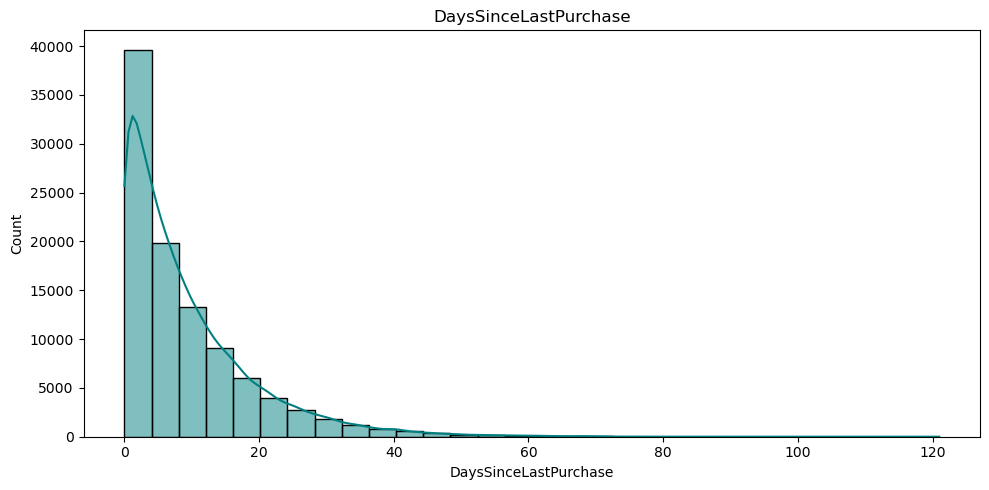

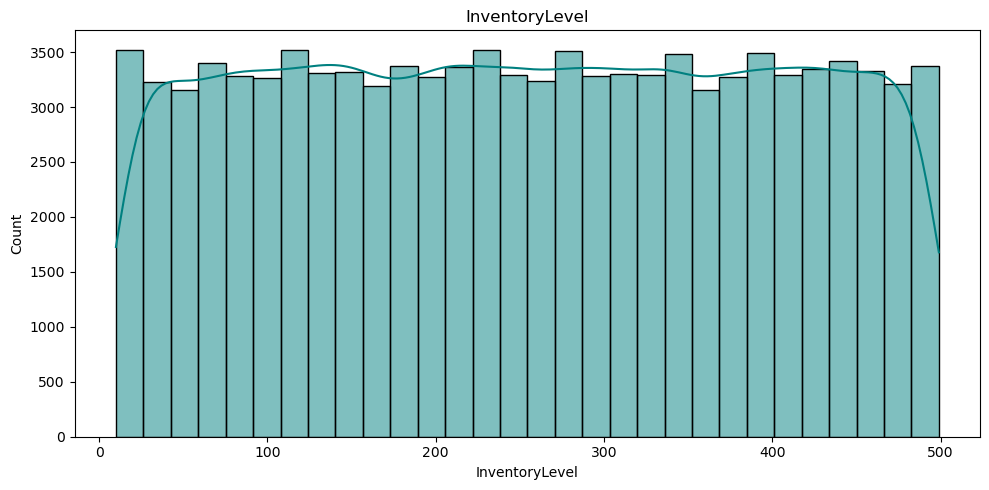

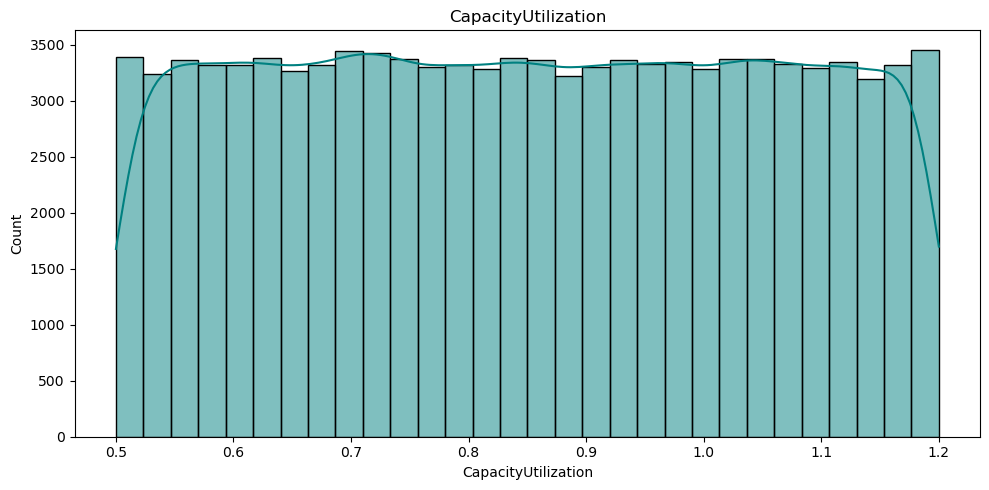

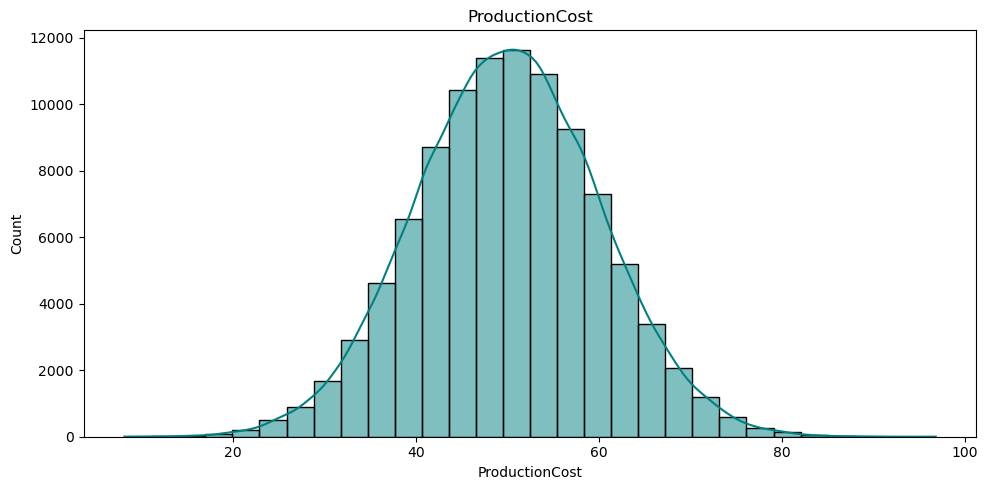

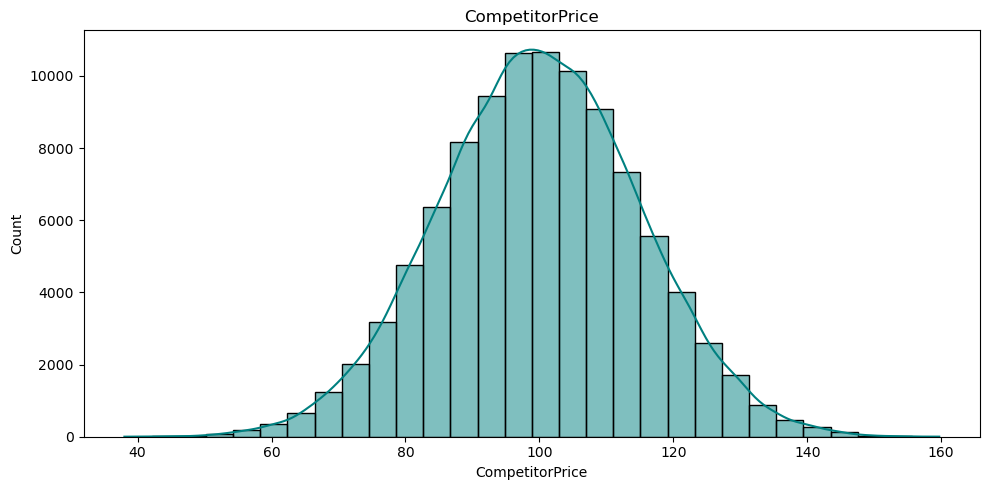

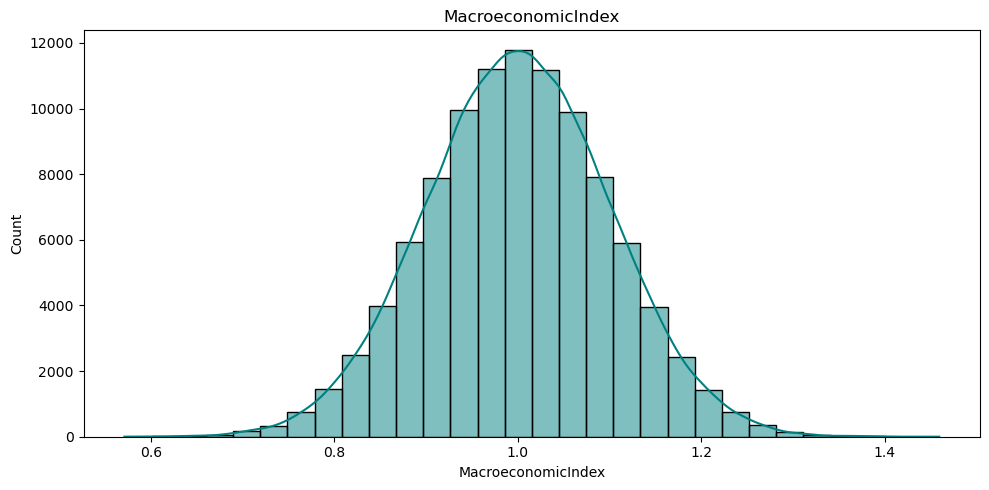

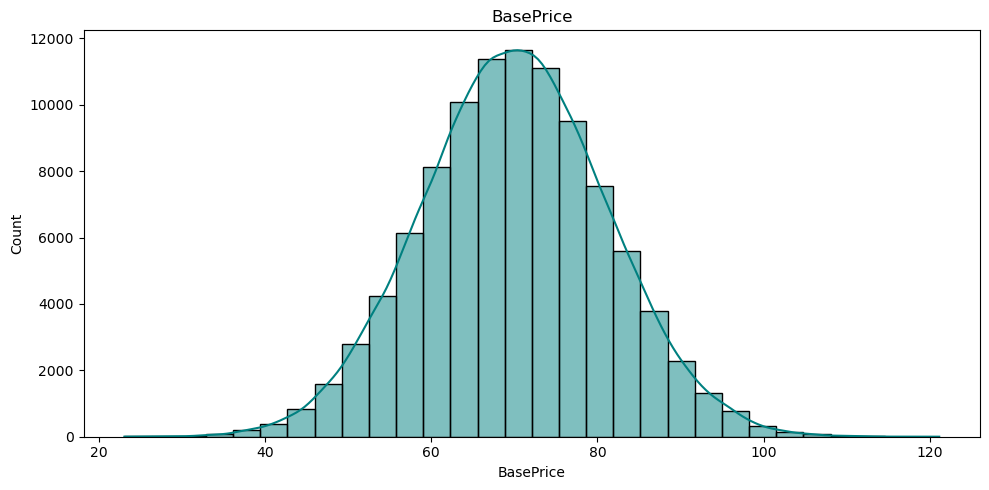

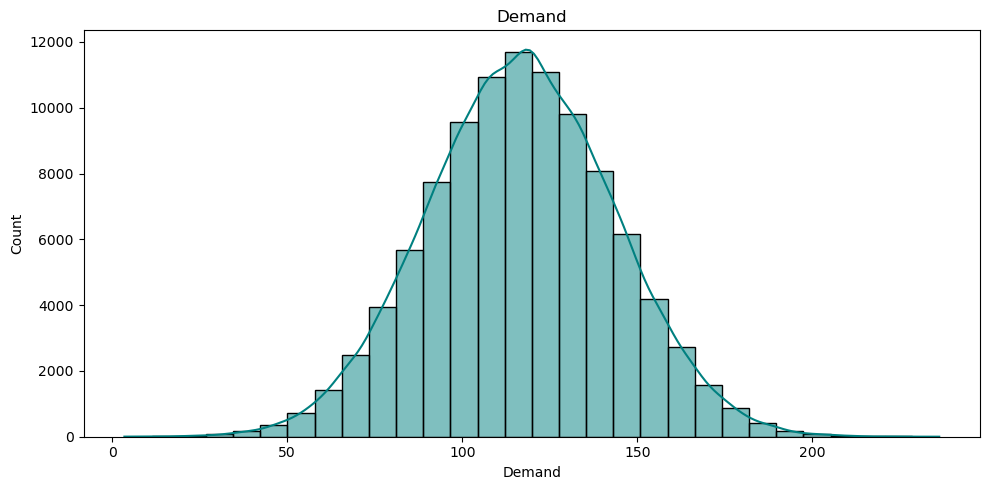

In [12]:
# Quick chweck on the data distribution
plot_numeric_distributions(
    df=num_df,
    num_cols=num_cols_filt,
    color='teal'
)

#### Dynamic Pricing Engine

In [13]:
# Constructing the dynamic pricing engine 
class DynamicPricingEngine:
    """
    Dynamic Pricing Engine:
    
    - Trains a demand model
    - Computes AlgorithmScore from real signals
    - Recommends prices using segment-aware elasticity and confidence scaling
    - Returns results merged with ALL original dataframe columns
    
    """

    def __init__(self, categoricals=None, drop_cols=None, segment_elasticity=None):
        self.categoricals = categoricals or ['Segment', 'Season', 'TimeOfDay', 'MarketPositioning', 'Weather']
        
        # Drop identifiers and target
        self.drop_cols = drop_cols or ['CustomerID', 'Demand', 'SKU', 'PurchaseDate']
        self.segment_elasticity = segment_elasticity or {
            'Budget': -1.1,
            'Standard': -0.8,
            'Premium': -0.5
        }
        self.model = LinearRegression()
        self.scaler = StandardScaler()
        self.feature_cols_ = None
        self.history_ = []  # store recent errors/volatility for confidence

    # ---------- Demand Model Training ----------
    def fit(self, df):
        """Train demand model on fabricated or real data."""
        df_enc = pd.get_dummies(df.copy(), columns=self.categoricals, drop_first=True)
        X = df_enc.drop(columns=self.drop_cols)
        y = df_enc['Demand']

        self.feature_cols_ = X.columns.tolist()
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)

        # Initialize history with baseline errors from training residuals
        preds = self.model.predict(X_scaled)
        residuals = y.values - preds
        self._update_history(residuals)

    # ---------- Adjusted price based on confidence level ----------
    def recommend_price(self, row):
        """Recommend adjusted price for a single row (dict or Series)."""
        row_df = self._prepare_row(row)
        X_scaled = self.scaler.transform(row_df[self.feature_cols_])
        pred_demand = float(self.model.predict(X_scaled)[0])

        # Compute confidence score
        algo_score, components = self.score_confidence(row_df, pred_demand)

        # Segment-aware elasticity
        seg = self._infer_segment(row)
        elasticity = self.segment_elasticity.get(seg, -0.9)

        # Confidence-scaled price adjustment
        base_price = float(row['BasePrice'])
        adjusted_price = self._adjust_price(base_price, pred_demand, elasticity, algo_score)

        # Update history with pseudo-residual
        self._update_history(np.array([pred_demand * 0.05 * np.random.choice([-1, 1])]))

        return {
            'predicted_demand': pred_demand,
            'algorithm_score': algo_score,
            'adjusted_price': adjusted_price,
            'elasticity': elasticity,
            'components': components
        }
        
    # ---------- Recommended price on a sample data ----------
    def simulate_batch(self, df, n=200, random_state=7):
        """Run recommendations for a sample batch and return results with ALL original columns."""
        sample = df.sample(n, random_state=random_state).copy()
        results = []

        for _, row in sample.iterrows():
            rec = self.recommend_price(row)
            row_dict = row.to_dict()
            row_dict.update({
                'PredictedDemand': rec['predicted_demand'],
                'AlgorithmScore': rec['algorithm_score'],
                'AdjustedPrice': rec['adjusted_price'],
                'Elasticity': rec['elasticity']
            })
            results.append(row_dict)

        return pd.DataFrame(results)
        
    # ---------- Recommended price on full data (Scaled)----------
    def simulate_full(self, df):
        """Run recommendations for the entire dataset and return results with ALL original columns."""
        results = []
        for _, row in df.iterrows():
            rec = self.recommend_price(row)
            row_dict = row.to_dict()
            row_dict.update({
                'PredictedDemand': rec['predicted_demand'],
                'AlgorithmScore': rec['algorithm_score'],
                'AdjustedPrice': rec['adjusted_price'],
                'Elasticity': rec['elasticity']
            })
            results.append(row_dict)
        return pd.DataFrame(results)

    # ---------- Confidence scoring ----------
    def score_confidence(self, row_df, pred_demand):
        components = {}
        x_scaled = self.scaler.transform(row_df[self.feature_cols_])
        dist = float(np.linalg.norm(x_scaled))
        uncertainty = np.tanh(dist / 10.0)
        components['uncertainty'] = uncertainty

        vol = self._rolling_volatility()
        error_penalty = np.tanh(vol / 20.0)
        components['error_penalty'] = error_penalty

        one_hot_cols = [c for c in self.feature_cols_ if any(k in c for k in self.categoricals)]
        coverage = (row_df[one_hot_cols].values.sum() / max(len(one_hot_cols), 1))
        coverage_score = np.clip(coverage, 0, 1)
        components['coverage'] = coverage_score

        inv = float(row_df['InventoryLevel'].values[0])
        cap = float(row_df['CapacityUtilization'].values[0])
        context_vol = np.tanh(abs(cap - 1.0) * 2 + (100.0 / max(inv, 1)) / 5.0)
        components['context_volatility'] = context_vol

        exploration = 0.05
        components['exploration'] = exploration

        raw = (
            0.35 * coverage_score
            + 0.25 * (1 - uncertainty)
            + 0.20 * (1 - error_penalty)
            + 0.15 * (1 - context_vol)
            + 0.05 * exploration
        )
        algo_score = float(np.clip(raw, 0, 1))
        components['final_score'] = algo_score
        return algo_score, components

    # ---------- Internals ----------
    def _prepare_row(self, row):
        if isinstance(row, pd.Series):
            row = row.to_dict()
        row_df = pd.DataFrame([row])
        row_df = pd.get_dummies(row_df, columns=self.categoricals, drop_first=True)
        for c in self.feature_cols_:
            if c not in row_df.columns:
                row_df[c] = 0
        return row_df[self.feature_cols_]

    def _infer_segment(self, row):
        if isinstance(row, pd.Series):
            return row['Segment']
        return row.get('Segment', 'Standard')

    def _adjust_price(self, base_price, predicted_demand, elasticity, algo_score):
        demand_ratio = max(predicted_demand, 1) / 100.0
        step = elasticity * (demand_ratio - 1)
        adj = np.clip(step * (0.5 + 0.5 * algo_score), -0.20, 0.20)
        return base_price * (1 + adj)

    def _update_history(self, residuals):
        self.history_.extend(residuals.tolist())
        if len(self.history_) > 500:
            self.history_ = self.history_[-500:]

    def _rolling_volatility(self, window=100):
        if len(self.history_) < 5:
            return 0.0
        arr = np.array(self.history_[-window:])
        return float(np.std(arr))

In [14]:
# Fit engine
engine = DynamicPricingEngine()
engine.fit(df)

# Batch simulation (sample of 300 rows)
results_batch = engine.simulate_batch(df, n=300)
print(results_batch.head())

# Full simulation (all 10K rows)
results_full = engine.simulate_full(df)
print(results_full.head())

# Merge results back into original df
df_with_results = df.merge(
    results_full[['SKU','PurchaseDate','PredictedDemand','AlgorithmScore','AdjustedPrice','Elasticity']],
    on=['SKU','PurchaseDate'],
    how='left'
)
print(df_with_results.head())

   CustomerID        SKU        PurchaseDate   Segment      Season TimeOfDay  \
0        1356  SKU-09006 2025-10-24 13:09:00    Budget     Regular     Night   
1        4175  SKU-00684 2025-12-04 02:27:00   Premium  Off-season   Evening   
2        3196  SKU-05038 2025-12-01 21:07:00    Budget     Regular     Night   
3        2465  SKU-06167 2025-10-07 14:58:00  Standard     Regular     Night   
4        2641  SKU-06791 2025-10-22 12:48:00   Premium     Regular   Morning   

   DaysSinceLastPurchase  InventoryLevel  CapacityUtilization  ProductionCost  \
0                      2             472             0.713983       40.679856   
1                     16             440             0.819383       49.187584   
2                     27             373             0.699197       46.277199   
3                      0             433             0.814874       53.503006   
4                      0             245             1.009524       57.064946   

   ...  CompetitorPrice  MarketP

In [15]:
# Quick check on the dataframe
df_with_results.head()

,CustomerID,SKU,PurchaseDate,Segment,Season,TimeOfDay,DaysSinceLastPurchase,InventoryLevel,CapacityUtilization,ProductionCost,...,CompetitorPrice,MarketPositioning,MacroeconomicIndex,Weather,BasePrice,Demand,PredictedDemand,AlgorithmScore,AdjustedPrice,Elasticity
0,4174,SKU-02149,2025-10-01 00:00:00,Budget,Regular,Evening,5,162,1.174462,43.636465,...,94.679152,Mid,1.046599,Sunny,73.296965,76.083666,114.519224,0.401549,65.093441,-1.1
1,4507,SKU-00229,2025-10-01 00:01:00,Premium,Regular,Evening,4,19,0.728658,65.347622,...,95.910605,Low,1.020726,Cold,89.984675,133.434031,94.999144,0.304402,91.452129,-0.5
2,1860,SKU-01238,2025-10-01 00:02:00,Premium,Regular,Morning,8,470,0.968019,42.982447,...,77.911244,Low,1.022518,Sunny,65.076519,129.260797,122.077609,0.432196,59.932309,-0.5
3,2294,SKU-08510,2025-10-01 00:03:00,Standard,Off-season,Afternoon,14,153,1.022734,48.503103,...,90.090537,Mid,0.854196,Hot,64.768925,54.045143,109.456781,0.433936,61.255751,-0.8
4,2130,SKU-07647,2025-10-01 00:04:00,Budget,Off-season,Afternoon,5,289,0.723337,51.422327,...,110.044238,Low,0.950807,Sunny,82.385881,75.692441,117.267001,0.380434,71.585281,-1.1


In [38]:
# Quick check on the confidence score
df_with_results['AlgorithmScore'].describe()

count    100000.000000
mean          0.383507
std           0.038018
min           0.230896
25%           0.353207
50%           0.385810
75%           0.413767
max           0.468913
Name: AlgorithmScore, dtype: float64

In [39]:
# Quick check on the confidence score
df_with_results['Elasticity'].value_counts()

Elasticity
-0.8    40082
-1.1    39803
-0.5    20115
Name: count, dtype: int64

In [40]:
# Quick check on the SKUs
df_with_results.groupby('Elasticity').agg(
    distSKU=('SKU', 'nunique')
)

,distSKU
Elasticity,
-1.1,9813
-0.8,9838
-0.5,8633


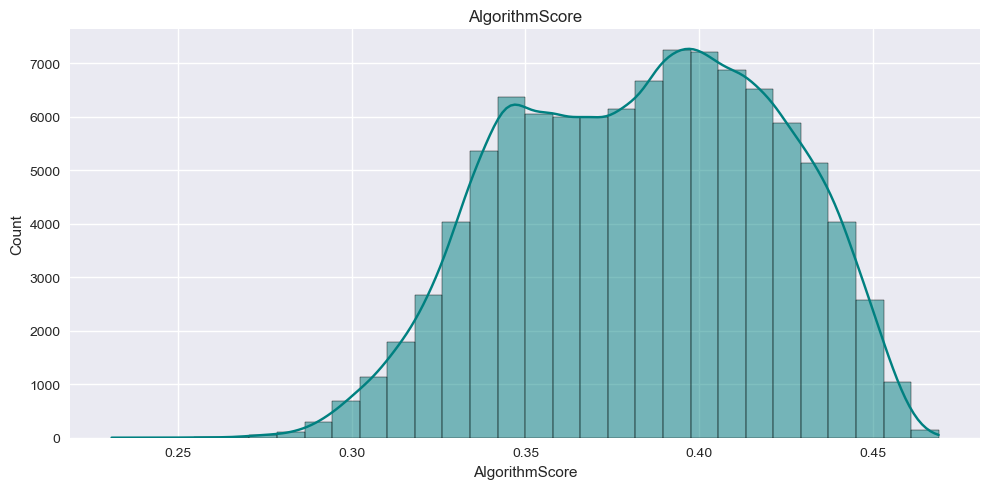

In [41]:
# Quick check on the confidence score
plot_numeric_distributions(
    df=df_with_results,
    num_cols=['AlgorithmScore'],
    color='teal'
)

In [42]:
# Quick check on the customers with maximum records
df_with_results.groupby('CustomerID')['PurchaseDate'].count().reset_index().sort_values('PurchaseDate', ascending=False).head()

,CustomerID,PurchaseDate
743,1743,44
2838,3838,43
1772,2772,42
386,1386,42
3810,4810,42


In [43]:
# Creating a temporary dataframe
df_cust = df_with_results[df_with_results['CustomerID'] == 1743]

In [44]:
# Quick check on the dataframe
df_cust.head()

,CustomerID,SKU,PurchaseDate,Segment,Season,TimeOfDay,DaysSinceLastPurchase,InventoryLevel,CapacityUtilization,ProductionCost,...,CompetitorPrice,MarketPositioning,MacroeconomicIndex,Weather,BasePrice,Demand,PredictedDemand,AlgorithmScore,AdjustedPrice,Elasticity
3114,1743,SKU-06188,2025-10-03 03:54:00,Standard,Regular,Afternoon,16,477,0.660499,40.331996,...,78.308817,High,1.130136,Hot,68.458118,142.719533,106.943041,0.359829,65.872771,-0.8
3449,1743,SKU-08406,2025-10-03 09:29:00,Standard,Off-season,Night,7,164,1.185175,33.152143,...,84.041930,High,0.925717,Rainy,53.252790,108.770972,119.079350,0.379884,47.644784,-0.8
12447,1743,SKU-08518,2025-10-09 15:27:00,Budget,Regular,Morning,14,115,0.504331,30.261076,...,120.008536,High,0.871813,Sunny,48.463837,148.397629,142.636381,0.313345,38.771069,-1.1
17326,1743,SKU-04656,2025-10-13 00:46:00,Budget,Holiday,Evening,3,33,0.611231,67.309443,...,81.622534,Mid,0.819421,Sunny,90.277644,72.566357,89.910424,0.299761,96.789120,-1.1
20455,1743,SKU-03749,2025-10-15 04:55:00,Budget,Holiday,Morning,11,12,0.912244,44.865470,...,91.440768,Mid,1.167456,Sunny,62.255975,105.960910,120.179740,0.304813,53.240105,-1.1


In [45]:
# Quick check on the SKUs
df_cust.groupby('Elasticity').agg(
    distSKU=('SKU', 'nunique')
)

,distSKU
Elasticity,
-1.1,22
-0.8,20
-0.5,2


Generated sweet spot analysis plot showing how demand varies with adjusted price across price bins.


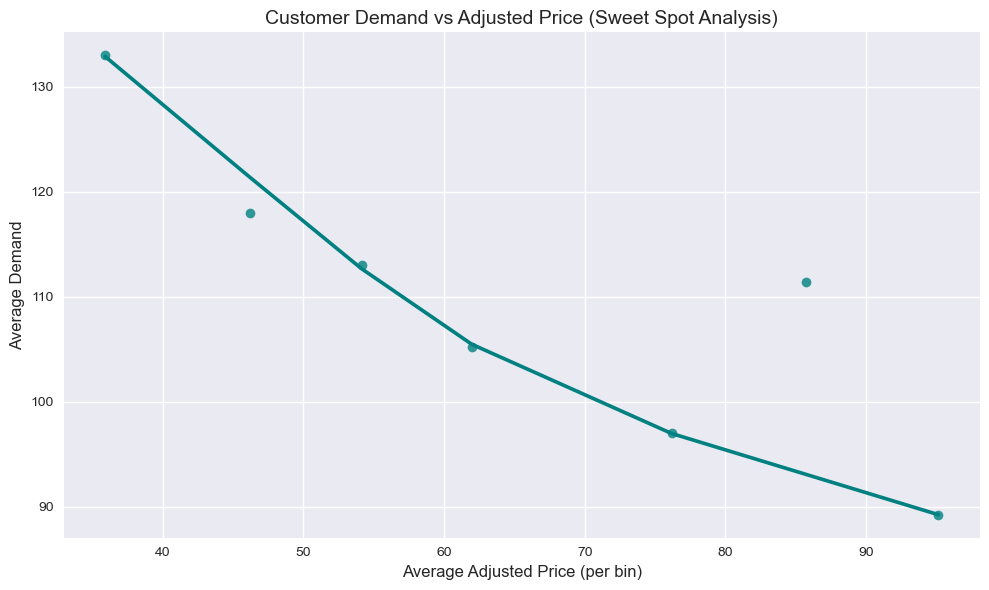

In [46]:
# Creating price bins
price_bin_width = 10
df_cust['PriceBin'] = pd.cut(df_cust['AdjustedPrice'], 
                        bins=np.arange(0, df_cust['AdjustedPrice'].max() + price_bin_width, price_bin_width))

# Computing average adjusted price and demand
bin_summary = df_cust.groupby('PriceBin').agg({
    'AdjustedPrice': 'mean',
    'Demand': 'mean'
}).reset_index()

# Visualising the results
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))
sns.regplot(data=bin_summary, x='AdjustedPrice', y='Demand', scatter=True, lowess=True, color='teal')
plt.title('Customer Demand vs Adjusted Price (Sweet Spot Analysis)', fontsize=14)
plt.xlabel('Average Adjusted Price (per bin)', fontsize=12)
plt.ylabel('Average Demand', fontsize=12)
plt.grid(True)
plt.tight_layout()
# plot_path = "/mnt/data/sweetspot_demand_vs_price.png"
# plt.savefig(plot_path)

print("Generated sweet spot analysis plot showing how demand varies with adjusted price across price bins.")